# Deep embedding clustering

Se comparan los métodos de clustering espacial utilizados en la literatura con el método DEC propuesto por Xie y co. 2016. Originalmente esta metodología no sigue restricciones espaciales que fueron agregadas a los fines de  este trabajo.

In [1]:
from SDEC.datos.codigos.lectura_datos import *
#import regionalizacion as reg
import matplotlib.pyplot as plt
import SDEC.regionalizacion.deep_cluster as dc
from sklearn.cluster import KMeans, AgglomerativeClustering
import rpy2.robjects as ro
import pickle 
import copy
dir_datos = "datos"

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

c:\Anaconda3\envs\espacial\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

C

: 

: 

In [ ]:
covid,geo, centroides, codiprov,covid_acum,personas = df_covid()

El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


## Armado de regiones

Se forman 6 regiones que van a tener comportamientos diferentes entre sí. Dentro de cada región los departamentos tienen el mismo comportamiento de base.

In [ ]:
codiprov.groupby('provincia').describe()

regiones = {'noroeste' : ('Jujuy','Salta','Tucumán','Santiago del Estero','Catamarca'),
            'noreste'  : ('Formosa', 'Chaco', 'Misiones','Corrientes','Santa Fe','Entre Ríos'),
            'cuyo' : ('La Rioja','San Juan','Mendoza','San Luis'),
            'pampeana' : ('Córdoba', 'La Pampa', 'Buenos Aires','Ciudad Autónoma de Buenos Aires' ),
            'patagonia' : ('Neuquén', 'Río Negro', 'Chubut', 'Santa Cruz', 'Tierra del Fuego')    
    }


lista_regiones = []
errores = []
for i in range(len(codiprov)):
    prov = codiprov.iloc[i].provincia
    j = 1
    pertenece = False
    for k in regiones.keys():
        l = regiones[k]
        if prov in l:
            lista_regiones.append(j)
            pertenece = True
        else:
        
            pass
        j += 1
    if pertenece == False:
        errores.append(codiprov.iloc[i]) 


cov =  covid.loc[pd.IndexSlice[:,'2021-01'],:].copy()
cov['reg'] = lista_regiones

regiones = cov.reg.copy()
regiones[cov.provincia == "Tucumán"] = 6
cov['reg'] = regiones

El comportamiento de cada región va estar dado por una función base que depende del periodo de tiempo, en esta caso son funciones cuadráticas que la única variación que tienen entre regiones es el valor máximo y el periodo en que llegan al mismo. Se considera el comportamiento de dos variables por cada departamento. Dado el problema que tenemos lo que se va modificando es la tasa de proporción de la población de cada departamento.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('standard', StandardScaler())#,
                 #('normalizer', Normalizer('l1'))
                 ])

func = {1 : lambda x : 0.14-((x-50)/100)**2,
     2 : lambda x : 0.25-((x-30)/100)**2,
     3 : lambda x : 0.20-((x-80)/100)**2,
     4 : lambda x : 0.10-((x-50)/100)**2,
     5 : lambda x : 0.3-((x-50)/100)**2,
     6 : lambda x : 0.3-((x-50)/100)**2
     }

x = cov.reg.map(func)


func2 = {1 : lambda x : 0.14-((2*x-90)/160)**2,
     2 : lambda x : 0.25-((2*x-100)/160)**2,
     3 : lambda x : 0.20-((2*x-150)/160)**2,
     4 : lambda x : 0.20-((2*x-100)/160)**2,
     5 : lambda x : 0.15-((2*x-120)/160)**2,
     6 : lambda x : 0.3-((2*x-120)/160)**2
     }

x2 = cov.reg.map(func2)

Para agregar ruido al modelo, por cada departamento se le agega un componente aleatorio que proviene de una distribución uniforme con intérvalo $[a,b) con b > a$ pero como se trata de proporciones se controla que dicho valor no sea menor a 0. Por lo tanto la fórmula de la proporción por departamento queda asi:

$x_t = f_R(t) + (b-a)*rand + a $

$y_t = x_t, si x_t > 0 $

$y_t = 0; en caso contrario$

siendo $f_R(t)$  la función de la resgión a la que pertenece el área.


In [ ]:
np.random.seed(3264)

def genera_datos(periodos,amplitud):
  periodos = periodos
  p = np.arange(0,periodos)
  varianz = amplitud

  val = []
  for i in x:
      y = i(p)+(np.random.rand()-0.5)*varianz
      val.append(y)
  val = np.array(val)

  val2 = []
  for i in x2:
      y = i(p)+(np.random.rand()-0.5)*varianz
      val2.append(y)
  val2 = np.array(val2)
  v = np.c_[(val * (val > 0)),(val2 * (val2 > 0))] 
  return v

En este primer caso tomamos el modelo más sencillo dónde no existe el componente aleatorio

In [ ]:
sim1 = genera_datos(100,0)
sim1_st = pipe.fit_transform(sim1)

In [ ]:
from libpysal.weights import KNN

In [ ]:
W_knn = KNN.from_dataframe(cov, ids = cov.index.get_level_values(0), k = 6 )

In [ ]:
aglo_esp = AgglomerativeClustering(6, connectivity= W_knn.sparse)
aglo_esp.fit(sim1_st)
km = KMeans(6)
km.fit(sim1_st)


KMeans(n_clusters=6)

<AxesSubplot:>

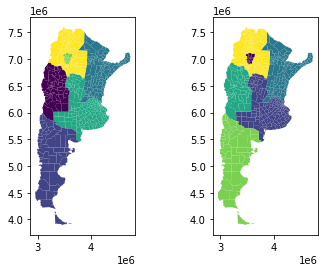

In [ ]:
fig, ax = plt.subplots(1,2)
cov.plot(aglo_esp.labels_, ax = ax[0])
cov.plot(km.labels_, ax = ax[1])

In [ ]:
from sklearn.metrics import *
def metricas_intrinsecas(datos, grupos):
    sil = round(silhouette_score(datos,grupos),5)
    cal = round(calinski_harabasz_score(datos,grupos),5)
    dav = round(davies_bouldin_score(datos, grupos),5)
    rdo = pd.DataFrame([sil,cal,dav], index = ['Siluetas', 'Kalinski','Davies'])
    return rdo

def metricas_extrinsecas(y_verd, y_pred):
    ami = adjusted_mutual_info_score(y_verd, y_pred)
    mi = mutual_info_score(y_verd, y_pred)
    hom = homogeneity_score(y_verd, y_pred)
    ran = rand_score(y_verd, y_pred)
    rdo = pd.DataFrame([ami,mi,hom,ran], index = ['Adj Mutual Inf', 'Mutual Inf', 'Homog','Rand score'])
    return rdo


In [ ]:
metricas_intrinsecas(sim1_st, km.labels_)

,0
Siluetas,1.000000e+00
Kalinski,5.452595e+31
Davies,0.000000e+00


In [ ]:
metricas_extrinsecas(cov.reg, km.labels_)

,0
Adj Mutual Inf,1.000000
Mutual Inf,1.586498
Homog,1.000000
Rand score,1.000000


Cómo se ve en este primer caso todos los algoritmos llegan al resultado perfecto. Así lo marcan las métricas de rendimiento también que tienen valores altos para todas las cálculadas. El índice LQ es el único que no llega a valor 1 como debíera marcar, pero este se calcula en base a intérvalos de confianza y  el resultado dado puede que no este bien separado en este sentido. 

Cabe aclarar que los algoritmos NO espaciales en este caso han funcionado bien pero porque no hay variabilidad y las regiones construidas son por esencia espaciales, en caso de que alguno de estos parámetros varíe encuentran resultados mucho más desordenados en el territorio

### Caso 2

En el segundo caso vamos a tomar una amplitud del espacio random de 0.5

In [ ]:
np.random.seed(3264)

sim2 = genera_datos(100,0.5)
sim2_st = pipe.fit_transform(sim2)

gdf = gpd.GeoDataFrame(sim2_st, columns = np.array(range(200), str), geometry = cov.reset_index().geometry)
gdf.to_file("SDEC/datos/simulaciones/sim2.shp")

c:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
km.fit(sim2_st)
aglo_esp.fit(sim2_st)
rdos_ext = pd.concat([metricas_extrinsecas(cov.reg, km.labels_),metricas_extrinsecas(cov.reg, aglo_esp.labels_)], axis = 1)
rdos_ext.columns = ['K-means','Aglo espacial']
rdos_ext

,K-means,Aglo espacial
Adj Mutual Inf,0.231321,0.571125
Mutual Inf,0.392218,0.901121
Homog,0.247222,0.567994
Rand score,0.695718,0.763548


In [ ]:
rdos_int = pd.concat([metricas_intrinsecas(sim2_st, km.labels_),metricas_intrinsecas(sim2_st, aglo_esp.labels_)], axis = 1)
rdos_int.columns = ['K-means','Aglo espacial']
rdos_int

,K-means,Aglo espacial
Siluetas,0.34990,0.10604
Kalinski,254.89174,57.95331
Davies,1.10216,2.94145


In [ ]:
sim1_st.shape

(525, 200)

In [ ]:
def calc_sdec(datos, W):
    X = datos
    X1 = datos[:,:100]
    X2 = datos[:,100:]
    sdec = dc.sdec(6)
    sdec.gen_modelo()
    sdec.train_autoencoder([X1,X2],X)
    sdec.ajustar_modelo([X1,X2], W.sparse)
    return sdec

In [ ]:
sdec = calc_sdec(sim2_st, W_knn)


In [ ]:
rdos_ext['SDEC'] = metricas_extrinsecas(cov.reg,sdec.y_pred)
rdos_ext

,K-means,Aglo espacial,SDEC
Adj Mutual Inf,0.231321,0.571125,0.925104
Mutual Inf,0.392218,0.901121,1.470516
Homog,0.247222,0.567994,0.926895
Rand score,0.695718,0.763548,0.979229


In [ ]:
rdos_int['SDEC'] = metricas_intrinsecas(sim2_st,sdec.y_pred)
rdos_int

,K-means,Aglo espacial,SDEC
Siluetas,0.34990,0.10604,0.00249
Kalinski,254.89174,57.95331,38.13867
Davies,1.10216,2.94145,4.19716


#### Entorno de R

Trabajamos con rgeoda

In [ ]:
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri,pandas2ri
from rpy2.robjects import default_converter

In [ ]:
with localconverter(default_converter+numpy2ri.converter) as cv:
    sim2_R = ro.conversion.py2rpy(sim2_st)
    W_R = ro.conversion.py2rpy(W_knn.sparse.todense())

ro.r.assign("sim2", sim2_R)
ro.r.assign("W", W_R)

0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000


In [ ]:
%%R
install.packages("rgeoda")
library(rgeoda)
library(digest)
library(spdep)

rdos <- matrix(nrow = 525)
rdos <- as.data.frame(rdos)
sim2 <- st_read("SDEC/datos/simulaciones/sim2.shp")
w_knn <- knn_weights(sim2,6)
sk <- rgeoda::skater(k = 6, w = w_knn, df = sim2)
rdos['skater'] <- sk$Clusters
redcap <- rgeoda::redcap(k = 6, w = w_knn, df = sim2)
rdos['redcap'] <- redcap$Clusters
schc <- rgeoda::schc(k = 6, w = w_knn, df = sim2)
rdos['schc'] <- schc$Clusters
rdos <- rdos[,2:4]


R[write to console]: Installing package into 'D:/Archivos/documentos/R/win-library/4.1'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://cran.dcc.uchile.cl/bin/windows/contrib/4.1/rgeoda_0.0.9.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2781747 bytes (2.7 MB)

R[write to console]: downloaded 2.7 MB




package 'rgeoda' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Pablo\AppData\Local\Temp\Rtmp0KdNGU\downloaded_packages


R[write to console]: Loading required package: digest

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 7.2.1

R[write to console]: 
Attaching package: 'spdep'


R[write to console]: The following object is masked from 'package:rgeoda':

    skater




Reading layer `sim2' from data source 
  `D:\Archivos\Codigos\clustering espacial\SDEC\datos\simulaciones\sim2.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 525 features and 200 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 2952701 ymin: 3898217 xmax: 4740787 ymax: 7596382
Projected CRS: POSGAR 2007 / Argentina 3
aaa0after gda_skater

In [ ]:
rdos_en_r = ro.r['rdos']
with localconverter(default_converter+pandas2ri.converter):
    rdo_rgeoda = ro.conversion.rpy2py(rdos_en_r)
rdo_rgeoda

,skater,redcap,schc
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
5,1,1,1
...,...,...,...
521,6,5,1
522,6,5,1
523,6,5,1
524,3,3,1


In [ ]:
rdos_int['skater'] = metricas_intrinsecas(sim2_st,rdo_rgeoda.skater)
rdos_int['redcap'] = metricas_intrinsecas(sim2_st,rdo_rgeoda.redcap)
rdos_int['schc'] = metricas_intrinsecas(sim2_st,rdo_rgeoda.schc)
rdos_int

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Siluetas,0.34990,0.10604,0.00249,0.07455,0.10535,0.13320
Kalinski,254.89174,57.95331,38.13867,36.26427,43.75215,3.49700
Davies,1.10216,2.94145,4.19716,3.11341,2.52550,0.62007


In [ ]:
rdos_ext['skater'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.skater)
rdos_ext['redcap'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.redcap)
rdos_ext['schc'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.schc)
rdos_ext

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Adj Mutual Inf,0.231321,0.571125,0.925104,0.629987,0.606403,0.026365
Mutual Inf,0.392218,0.901121,1.470516,0.912408,0.864784,0.037714
Homog,0.247222,0.567994,0.926895,0.575108,0.545090,0.023772
Rand score,0.695718,0.763548,0.979229,0.762101,0.752955,0.255914


Cuando agegamos ruido a los modelos ya los métodos que no son espaciales presentan severas dificultades para encontrar la respuesta, presentan resultados muy desordenados.

Los métodos espaciales que se presentan por rgeoda no trabajan mal, el que mejor lo hace es el método skater sin considerar los autoencoders. 

Pero para este caso con mayor variabilidad el método propuesto DEC supera ampliamente a todos los demás. Esto se puede ver visualmente y tambien por el indicador de mutual información. El problema que hay es con las métricas intrínseca. Estas arrojan valores peores que los demás modelos, pero si vemos la salida del resultado real, vemos que son muy similares a estas, lo que está fallando en este caso son las métricas.

### Caso 3

Tomammos una amplitud de 1

In [ ]:
np.random.seed(3264)

sim3 = genera_datos(100,1)
sim3_st =  pipe.fit_transform(sim3)

gdf = gpd.GeoDataFrame(sim3_st, columns = np.array(range(200), str), geometry = cov.reset_index().geometry)
gdf.to_file("SDEC/datos/simulaciones/sim3.shp")

c:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
sdec = calc_sdec(sim3_st, W_knn)
rdos_ext['SDEC'] = metricas_extrinsecas(cov.reg,sdec.y_pred)
rdos_ext

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Adj Mutual Inf,0.231321,0.571125,0.781708,0.404106,0.372873,0.016914
Mutual Inf,0.392218,0.901121,1.292237,0.535890,0.544100,0.028901
Homog,0.247222,0.567994,0.814522,0.337782,0.342956,0.018217
Rand score,0.695718,0.763548,0.914213,0.579280,0.666041,0.252177


In [ ]:
rdos_int['SDEC'] = metricas_intrinsecas(sim3_st,sdec.y_pred)
rdos_int

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Siluetas,0.34990,0.10604,-0.07801,-0.07977,-0.06623,0.00856
Kalinski,254.89174,57.95331,14.21602,17.81094,24.77848,2.95743
Davies,1.10216,2.94145,5.03869,2.92610,2.93302,0.61675


In [ ]:
%%R
rdos <- matrix(nrow = 525)
rdos <- as.data.frame(rdos)
sim2 <- st_read("SDEC/datos/simulaciones/sim3.shp")
w_knn <- knn_weights(sim2,6)
sk <- rgeoda::skater(k = 6, w = w_knn, df = sim2)
rdos['skater'] <- sk$Clusters
redcap <- rgeoda::redcap(k = 6, w = w_knn, df = sim2)
rdos['redcap'] <- redcap$Clusters
schc <- rgeoda::schc(k = 6, w = w_knn, df = sim2)
rdos['schc'] <- schc$Clusters
rdos <- rdos[,2:4]

#azp_tabu <- rgeoda::azp_tabu(6, w_knn, sim2, tabu_length = 10, conv_tabu = 10)
#rdos['azp_tabu'] <- azp_tabu$Clusters

Reading layer `sim3' from data source 
  `D:\Archivos\Codigos\clustering espacial\SDEC\datos\simulaciones\sim3.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 525 features and 200 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 2952701 ymin: 3898217 xmax: 4740787 ymax: 7596382
Projected CRS: POSGAR 2007 / Argentina 3
aaa0after gda_skater

In [ ]:
rdos_en_r = ro.r['rdos']
with localconverter(default_converter+pandas2ri.converter):
    rdo_rgeoda = ro.conversion.rpy2py(rdos_en_r)
rdo_rgeoda

,skater,redcap,schc
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
5,1,1,1
...,...,...,...
521,1,2,1
522,1,2,1
523,1,2,1
524,4,4,1


In [ ]:
rdos_int['skater'] = metricas_intrinsecas(sim3_st,rdo_rgeoda.skater)
rdos_int['redcap'] = metricas_intrinsecas(sim3_st,rdo_rgeoda.redcap)
rdos_int['schc'] = metricas_intrinsecas(sim3_st,rdo_rgeoda.schc)
rdos_int

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Siluetas,0.34990,0.10604,-0.07801,-0.05590,-0.05315,0.03836
Kalinski,254.89174,57.95331,14.21602,18.28857,24.66595,3.05062
Davies,1.10216,2.94145,5.03869,2.92953,2.90883,0.59956


In [ ]:
rdos_ext['skater'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.skater)
rdos_ext['redcap'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.redcap)
rdos_ext['schc'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.schc)
rdos_ext

,K-means,Aglo espacial,SDEC,skater,redcap,schc
Adj Mutual Inf,0.231321,0.571125,0.781708,0.404106,0.372873,0.016914
Mutual Inf,0.392218,0.901121,1.292237,0.535890,0.544100,0.028901
Homog,0.247222,0.567994,0.814522,0.337782,0.342956,0.018217
Rand score,0.695718,0.763548,0.914213,0.579280,0.666041,0.252177


In [ ]:
X1 = sim3_st[:,:100]
X2 = sim3_st[:,100:]

pred = sdec.autoencoder.predict([X1,X2])

In [ ]:
mean_squared_error(pred, sim3_st)

0.999873690077859

-50181.13700519187 0.0


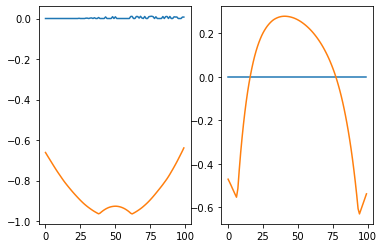

In [ ]:
v = 64
cont_pred, fall_pred = pred[v,:100],pred[v,100:]
cont_real, fall_real = sim3_st[v,:100],sim3_st[v,100:]
print(r2_score(cont_pred, cont_real),r2_score(fall_pred, fall_real))
fig, ax = plt.subplots(1,2)
ax[0].plot(cont_pred)# = plt.plot(cont_pred)
ax[0].plot(cont_real)
ax[1].plot(fall_pred)
ax[1].plot(fall_real)

In [ ]:
var1 = pipe.fit_transform(sim3[:,:100].reshape(525*100,1))
var1 = var1.reshape(525,100)
var2 = pipe.fit_transform(sim3[:,100:].reshape(525*100,1))
var2 = var2.reshape(525,100)


In [ ]:
sdec2 = calc_sdec(np.c_[var1,var2], W_knn)

In [ ]:
rdos_ext2 = pd.DataFrame([])
rdos_ext2['skater'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.skater)
rdos_ext2['redcap'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.redcap)
rdos_ext2['schc'] = metricas_extrinsecas(cov.reg,rdo_rgeoda.schc)
rdos_ext2

,skater,redcap,schc
Adj Mutual Inf,0.404106,0.372873,0.016914
Mutual Inf,0.535890,0.544100,0.028901
Homog,0.337782,0.342956,0.018217
Rand score,0.579280,0.666041,0.252177


In [ ]:
rdos_ext2['sdec'] = metricas_extrinsecas(cov.reg, sdec2.y_pred)
rdos_ext2

,skater,redcap,schc,sdec
Adj Mutual Inf,0.404106,0.372873,0.016914,0.777022
Mutual Inf,0.535890,0.544100,0.028901,1.192243
Homog,0.337782,0.342956,0.018217,0.751493
Rand score,0.579280,0.666041,0.252177,0.895856


In [ ]:
pred = sdec.autoencoder.predict([var1,var2])

In [ ]:
mean_squared_error(pred, np.c_[var1,var2])

1.0005456906626105

-283483.2947173824 0.0


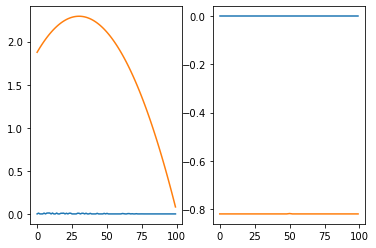

In [ ]:
v = 231
cont_pred, fall_pred = pred[v,:100],pred[v,100:]
cont_real, fall_real = var1[v],var2[v]
print(r2_score(cont_pred, cont_real),r2_score(fall_pred, fall_real))
fig, ax = plt.subplots(1,2)
ax[0].plot(cont_pred)# = plt.plot(cont_pred)
ax[0].plot(cont_real)
ax[1].plot(fall_pred)
ax[1].plot(fall_real)

In [ ]:
np.c_[var1,var2].shape

(525, 200)

In [ ]:
pred.shape

(525, 200)

(<AxesSubplot:>, <AxesSubplot:>)

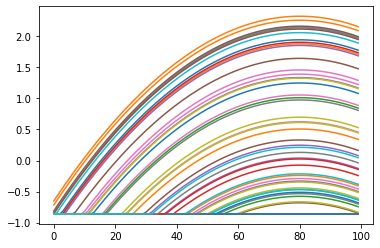

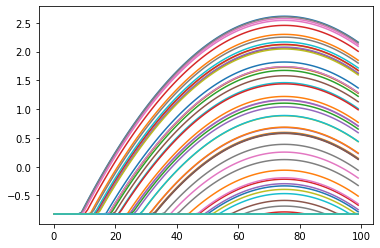

In [ ]:
pd.DataFrame(var1[sdec2.y_pred == 2]).T.plot(legend = False),pd.DataFrame(var2[sdec2.y_pred == 2]).T.plot(legend = False)

In [1]:
grupo = 0
pd.DataFrame(sim3[:,:100][sdec2.y_pred == grupo]).T.plot(legend = False),pd.DataFrame(sim3[:,100:][sdec2.y_pred == grupo]).T.plot(legend = False)

NameError: name 'pd' is not defined

(<AxesSubplot:>, <AxesSubplot:>)

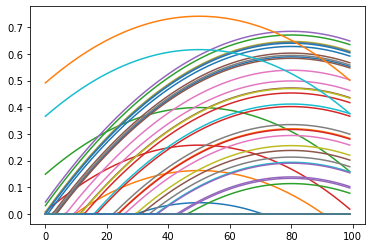

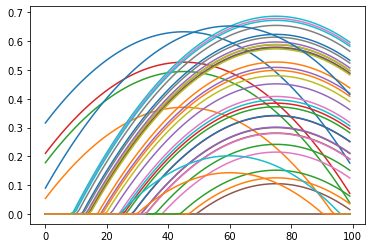

In [128]:
grupo = 3
pd.DataFrame(sim3[:,:100][rdo_rgeoda.redcap == grupo]).T.plot(legend = False),pd.DataFrame(sim3[:,100:][rdo_rgeoda.redcap == grupo]).T.plot(legend = False)